### PROYECTO DE MÓDULO 2
#### ASESORÍA 26 DE ABRIL DE 2021
#### PRESENTACIÓN 3 DE MAYO DE 2021


### EXAMEN FINAL: MIÉRCOLES 12 DE MAYO

### REFERENTE AL MÓDULO 3: ECUACIONES DIFERENCIALES. SOLO SE ENTREGARÁ EL INFORME ESCRITO, NO HABRÁ PRESENTACIÓN. SERÁ CORTO.

# Aplicando Python para análisis de precios: simulación de escenarios futuros de precios

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/d/d7/Philippine-stock-market-board.jpg" width="400px" height="125px" />

> En la clase anterior vimos como importar datos de activos de la base de datos de Yahoo Finance usando el paquete pandas-datareader. En esta clase, veremos como pronosticar escenarios de evolución de precios, suponiendo que los rendimientos diarios se distribuyen normalmente. Como esta evolución de precios es aleatoria, utilizaremos la simulación montecarlo (hacer muchas simulaciones de escenarios de evolución de precios) para obtener probabilidades de que los precios de cierre estén encima de un valor umbral y tomar decisiones con base en estas probabilidades.

**Referencias:**
- http://pandas.pydata.org/
- http://www.learndatasci.com/python-finance-part-yahoo-finance-api-pandas-matplotlib/

## 1. Recordemos como descargar datos...

Antes que nada, para poder hacer simular escenarios de predicción de precios, vamos a recordar lo que hicimos en la clase pasada de descargar los datos de Yahoo Finance, utilizando el paquete `data` de la librería `pandas_datareader`.

Esta vez, utilizaremos los datos de precios de cierre ajustados de activos de la compañía Apple en el año 2016 para nuestra aplicación.

In [1]:
# Importamos librerías
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Función para descargar precios de cierre ajustados de varios activos a la vez:
def get_closes(names, start, end):
    close = web.DataReader(names, 'yahoo', start, end)
    return close['Adj Close']

In [3]:
# Descargamos datos...
# Instrumentos: S&P 500, Apple 
names = ['^GSPC', 'AAPL']

# Fechas de interés (inicio y fin): 2015-2019
start = '2015-01-01'
end = '2019-12-31'

# Función DataReader
precios = get_closes(names, start, end)
precios

Symbols,^GSPC,AAPL
Date,,
2015-01-02,2058.199951,24.861401
2015-01-05,2020.579956,24.161013
2015-01-06,2002.609985,24.163294
2015-01-07,2025.900024,24.502111
2015-01-08,2062.139893,25.443539
...,...,...
2019-12-24,3223.379883,70.353882
2019-12-26,3239.909912,71.749733
2019-12-27,3240.020020,71.722488


<AxesSubplot:xlabel='Date'>

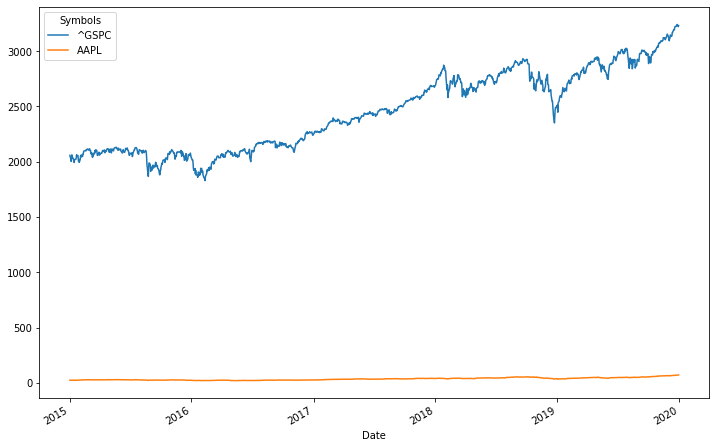

In [4]:
# Graficamos
precios.plot(figsize=(12,8))

## 2. Simulación de rendimientos diarios

Recordemos que los precios diarios de cierre ajustados no son un proceso estocástico estacionario, pero los rendimientos diarios si lo son. Por tanto calculamos los rendimientos a partir de los precios de cierre, obtenemos sus propiedades estadísticas muestrales y proyectamos los rendimientos. Luego, obtenemos la proyección de los precios.

Para una sucesión de precios $\{S_t\}_{t=0}^{n}$, el rendimiento simple $R_t$ se define como el cambio porcentual

$$
R_t=\frac{S_t-S_{t-1}}{S_{t-1}}\approx \ln\left(\frac{S_t}{S_{t-1}}\right)=r_t.
$$
para $t=1,\ldots,n$.

Para el ejemplo en curso, ¿cómo calcular esto?

Además, supusimos que los rendimientos diarios eran una variable aleatoria con distribución normal (que se caracteriza con su media y varianza). Por tanto obtenemos la media y desviación estandar muestrales. Hagamos una función que retorne lo anterior.

In [5]:
# Calcular rendimientos diarios y graficarlos
rendimientos = precios.pct_change()
rendimientos

Symbols,^GSPC,AAPL
Date,,
2015-01-02,NaN,NaN
2015-01-05,-0.018278,-0.028172
2015-01-06,-0.008893,0.000094
2015-01-07,0.011630,0.014022
2015-01-08,0.017888,0.038422
...,...,...
2019-12-24,-0.000195,0.000951
2019-12-26,0.005128,0.019840
2019-12-27,0.000034,-0.000380


Entonces, suponemos que el cambio porcentual de los precios (rendimientos diarios) tiene una distribución normal.

¿Cómo se caracteriza una [distribución normal](https://es.wikipedia.org/wiki/Distribuci%C3%B3n_normal)?

In [6]:
rendimientos.mean(), rendimientos.std()

(Symbols
 ^GSPC    0.000395
 AAPL     0.000976
 dtype: float64,
 Symbols
 ^GSPC    0.008466
 AAPL     0.015646
 dtype: float64)

<AxesSubplot:xlabel='Date'>

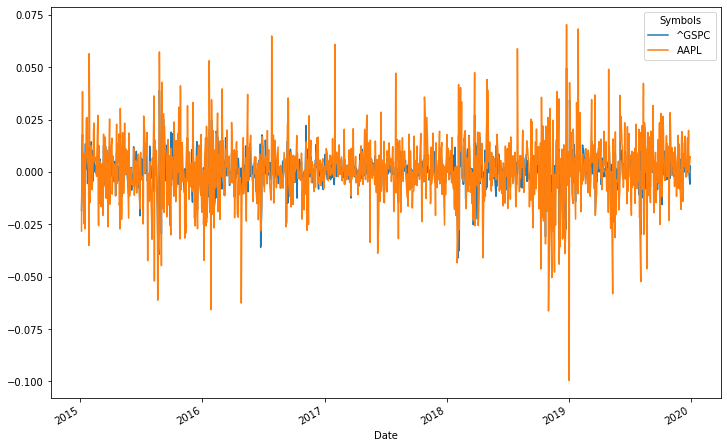

In [7]:
# Calculamos media y desviación estándar
rendimientos.plot(figsize=(12,8))

Habiendo caracterizado los rendimientos diarios como una variable aleatoria normal con la media y la varianza muestral obtenida de los datos del 2019, podemos generar números aleatorios con estas características para simular el comportamiento de los precios de cierre de las acciones en el 2020 (hay un supuesto de que las cosas no cambiarán fundamentalmente).

Sin embargo, cada simulación que hagamos nos conducirá a distintos resultados (los precios siguen evolucionando aleatoriamente). Entonces, lo que haremos es simular varios escenarios para así ver alguna tendencia y tomar decisiones.

Hagamos una una función que simule varios escenarios de rendimientos diarios y que devuelva un dataframe con esta simulación.

In [8]:
# Ayuda en la función np.random.randn
help(np.random.randn)

Help on built-in function randn:

randn(...) method of numpy.random.mtrand.RandomState instance
    randn(d0, d1, ..., dn)
    
    Return a sample (or samples) from the "standard normal" distribution.
    
    .. note::
        This is a convenience function for users porting code from Matlab,
        and wraps `standard_normal`. That function takes a
        tuple to specify the size of the output, which is consistent with
        other NumPy functions like `numpy.zeros` and `numpy.ones`.
    
    .. note::
        New code should use the ``standard_normal`` method of a ``default_rng()``
        instance instead; please see the :ref:`random-quick-start`.
    
    If positive int_like arguments are provided, `randn` generates an array
    of shape ``(d0, d1, ..., dn)``, filled
    with random floats sampled from a univariate "normal" (Gaussian)
    distribution of mean 0 and variance 1. A single float randomly sampled
    from the distribution is returned if no argument is provided.
 

In [9]:
5*np.random.randn(1,3)+3

array([[-0.32652713,  0.92791085,  8.4414299 ]])

In [10]:
# Función que simula varios escenarios de rendimientos diarios
def simulacion_rendimientos(mu, sigma, ndays, nscen, start_date):
    fechas = pd.date_range(start=start_date, periods=ndays)
    simulacion = sigma*np.random.randn(ndays, nscen)+mu  #Predicciones
    tabla = pd.DataFrame(index=fechas, data=simulacion)
    return tabla    

In [11]:
# Media y volatilidad
media = rendimientos.mean()
sigma = rendimientos.std()

sigma['AAPL']

0.01564608309101217

In [12]:
# Simulamos 100 escenarios para todo el 2020

#Simulación para Apple [AAPL]
media_AAPL = media['AAPL']
sigma_AAPL = sigma['AAPL']
nscen = 100
ndays = 365
start_date = '2020-01-01'

rendimientos_simulados_AAPL = simulacion_rendimientos(media_AAPL, 
                                                      sigma_AAPL, 
                                                      ndays, 
                                                      nscen, 
                                                      start_date)

In [13]:
# Mostrar
rendimientos_simulados_AAPL

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2020-01-01,-0.026571,-0.002562,0.004532,0.017092,-0.014632,-0.007356,0.004839,0.004159,-0.000331,-0.019635,...,0.003085,-0.007817,0.012557,-0.010367,0.003185,-0.015700,-0.001059,0.001784,0.000487,0.001084
2020-01-02,-0.005667,-0.001674,0.011460,0.034412,0.009083,0.032464,-0.008291,-0.007899,0.004731,-0.027365,...,0.027038,0.003850,0.003090,-0.025443,0.011688,-0.010506,0.000380,-0.030911,-0.014668,0.014418
2020-01-03,-0.029510,0.002997,0.023222,-0.013618,-0.002125,0.010911,-0.011302,-0.014906,0.010738,-0.008566,...,-0.008801,0.014855,0.007423,0.032815,0.016996,-0.010136,-0.004817,-0.025891,-0.013080,-0.007728
2020-01-04,0.017368,0.009371,0.002207,0.026940,-0.024017,-0.013159,-0.011058,-0.003970,0.044104,0.000680,...,-0.015561,-0.007816,0.015655,-0.018616,0.014998,0.024669,0.021750,-0.014769,0.006142,0.051554
2020-01-05,-0.009930,-0.014884,0.006230,0.017793,-0.002988,0.026535,0.033719,0.003488,-0.014462,0.005303,...,-0.007837,0.004930,-0.006960,-0.007936,0.017305,-0.008607,-0.004214,0.007246,-0.001761,-0.023935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-26,0.007825,0.000006,-0.001724,0.011124,0.000768,-0.004895,-0.038474,-0.003763,-0.012020,0.005670,...,-0.019385,0.018367,-0.009190,-0.011193,0.016172,-0.015107,0.010827,0.015104,-0.023676,-0.023339
2020-12-27,0.025337,-0.021350,0.010658,-0.011492,0.005409,-0.009784,-0.011371,-0.017933,-0.009841,0.029253,...,0.012751,0.019407,-0.002373,-0.016049,0.021142,0.010781,0.010176,-0.035038,0.013177,0.004362
2020-12-28,0.002274,0.015819,-0.022842,0.014848,0.022092,-0.014327,-0.000254,-0.017561,0.006161,0.025338,...,0.011445,-0.020334,0.016153,-0.011592,0.015065,0.005964,-0.003332,-0.013734,-0.004183,-0.025453
2020-12-29,-0.008895,0.027140,-0.001329,-0.017926,0.012904,0.015447,-0.004754,-0.016266,0.010809,0.007191,...,0.021181,0.012654,0.005565,-0.006339,-0.017995,0.035908,-0.000853,-0.027809,0.005522,-0.038937


## 3. Proyección de precios de cierre

$R_i = \frac{p_i-p_{i-1}}{p_{i-1}}$

$p_i = R_ip_{i-1}+p_{i-1}$

Por tanto, para calcular los precios, tenemos:

$$\begin{align}
p_i&=p_{i-1}(R_i+1)\\
p_{i+1}&=p_i(R_{i+1}+1)=p_{i-1}(R_i+1)(R_{i+1}+1)\\
&\vdots\\
p_{i+k}&=p_{i-1}(R_i+1)\cdots(R_{i+k}+1).
\end{align}$$

Si hacemos $i=0$ en la última ecuación, tenemos que $p_{k}=p_{-1}(R_0+1)\cdots(R_{k}+1)$, donde $p_{-1}$ es el último precio reportado en el 2017.

Con los rendimientos, calculamos los precios de cierre...

In [14]:
# Obtenemos los precios. 
# Transformar los rendimientos simulados del 2020 
# a precios de acción simulados del 2020.
precios_simulados_AAPL = precios['AAPL'][-1]*(1+rendimientos_simulados_AAPL).cumprod()
precios_simulados_AAPL

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2020-01-01,70.744258,72.489149,73.004727,73.917481,71.611958,72.140733,73.026981,72.977586,72.651287,71.248328,...,72.899554,72.107262,73.587936,71.921936,72.906829,71.534371,72.598412,72.804986,72.710705,72.754106
2020-01-02,70.343372,72.367826,73.841365,76.461100,72.262398,74.482726,72.421527,72.401132,72.995017,69.298631,...,74.870640,72.384855,73.815301,70.092025,73.758940,70.782852,72.625999,70.554521,71.644155,73.803094
2020-01-03,68.267572,72.584710,75.556117,75.419848,72.108846,75.295380,71.603039,71.321913,73.778826,68.705043,...,74.211692,73.460137,74.363210,72.392089,75.012538,70.065416,72.276139,68.727818,70.707052,73.232755
2020-01-04,69.453252,73.264888,75.722893,77.451622,70.376996,74.304570,70.811273,71.038772,77.032761,68.751765,...,73.056880,72.885983,75.527398,71.044458,76.137547,71.793888,73.848136,67.712808,71.141312,77.008232
2020-01-05,68.763564,72.174391,76.194679,78.829684,70.166730,76.276226,73.198941,71.286572,75.918742,69.116369,...,72.484339,73.245324,75.001699,70.480620,77.455105,71.175946,73.536917,68.203429,71.016050,75.165038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-26,80.887384,135.638843,70.600959,87.959889,83.340795,145.996709,95.233568,101.198454,59.243774,139.332621,...,113.919549,187.608836,96.609467,93.361003,80.060150,47.634249,92.615650,88.339556,86.990088,123.650717
2020-12-27,82.936825,132.742935,71.353447,86.949037,83.791623,144.568338,94.150689,99.383650,58.660774,143.408483,...,115.372093,191.249744,96.380234,91.862615,81.752747,48.147793,93.558151,85.244290,88.136345,124.190135
2020-12-28,83.125390,134.842791,69.723625,88.240037,85.642739,142.497092,94.126743,97.638371,59.022158,147.042109,...,116.692528,187.360894,97.937054,90.797707,82.984328,48.434934,93.246430,84.073576,87.767671,121.029108
2020-12-29,82.385965,138.502372,69.630996,86.658248,86.747847,144.698199,93.679224,96.050178,59.660105,148.099491,...,119.164238,189.731836,98.482122,90.222160,81.491059,50.174137,93.166929,81.735606,88.252358,116.316620


<AxesSubplot:>

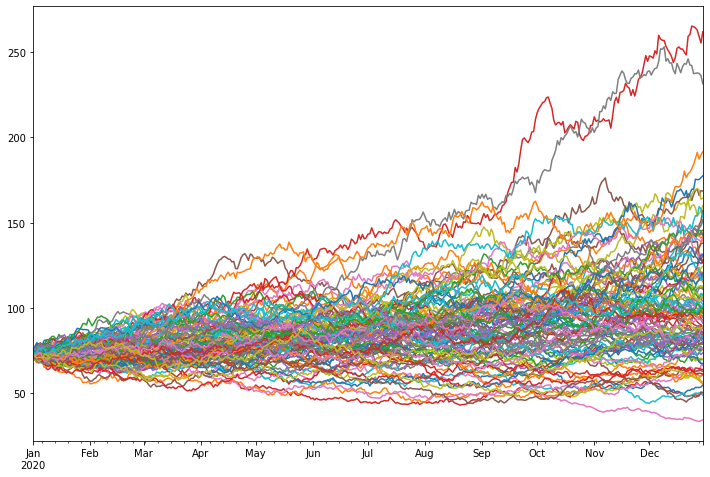

In [15]:
# Graficar
precios_simulados_AAPL.plot(figsize=(12,8), legend=False)

## 4. Probabilidad Precio-Umbral

Ya que tenemos muchos escenarios de precios proyectados, podemos ver varias cosas. Por ejemplo, ¿cuál es la probabilidad de que el precio de cierre sobrepase algún valor umbral en algún momento?

In [20]:
# Umbral de 110% del ultimo precio
K = precios['AAPL'][-1]*1.1

# Fechas
fechas = precios_simulados_AAPL.index

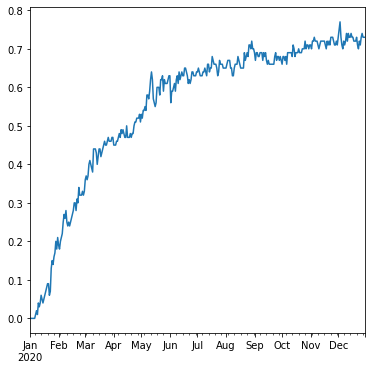

In [26]:
# Comparar cada escenario en cada fecha
TF = precios_simulados_AAPL > K

# Sumamos para cada fecha y dividimos entre el número de escenarios
prob = TF.sum(axis=1)/100

# Gráfico de probabilidad
prob.plot(figsize=(6,6))
plt.show()

In [27]:
# Descargamos datos...
# Instrumento: 
names = ['AAPL']

# Fechas de interés (inicio y fin): 2020
start = '2020-01-01'
end = '2020-12-31'

# Función DataReader
precios_real_AAPL = get_closes(names, start, end)

<AxesSubplot:xlabel='Date'>

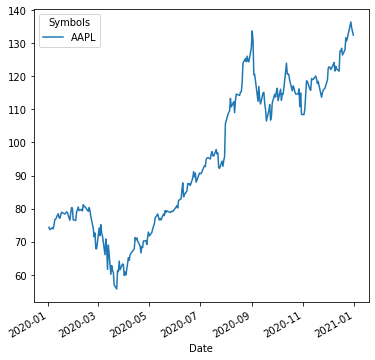

In [28]:
precios_real_AAPL.plot(figsize=(6,6))

___
Entonces, ya aprendimos a bajar datos con pandas-datareader. En específico, a partir de los precios de cierre ajustados obtuvimos los rendimientos diarios.

Suponiendo que los rendimientos diarios son un proceso estocástico estacionario de distribución normal, pudimos caracaterizarlo y proyectar varios escenarios de evolución de los precios (montecarlo).

Con estas proyecciones pudimos calcular probabilidades de sobrepasar cierto precio umbral: toma de decisiones.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Cristian Camilo Zapata Zuluaga.
</footer>